# Churn Prediction with Pyspark and Keras

# Introduction

This work was motivated by the lack (as of August of 2018) of a distributed framework allowing modeling with arbitrary keras models. Of particular interest are multi-input neural net models that allow the use of embedding layers. During training, embedding layers allow transforming categorical variables into a meaninful vector space from which insights could be extracted. 

In order to allow the distributed training of arbitrary keras models the associated modules were developed for a simple problem. This project was seeded by [this](https://github.com/bensadeghi/pyspark-churn-prediction) very didactic github repo.

# Distributed data exploration with pyspark

The dfhelper module has a number of useful functions for exploring the data. The general approach is to:
- get global statistics going through the data using spark native functions.
- plot using pandas by extracting a sample small enough to fit in memory.

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [1]:
import dfhelper

spark = dfhelper.init_session("local", "churn pred")

In [20]:
dfhelper.open_spark_browser_gui()

In [16]:
dfhelper.full_data_size_estimation(df_train)

started full dataframe count at 2018-07-29 11:28:29.640327
total number of rows: 2666
ended count at 2018-07-29 11:28:29.738698
time elapsed: 0.0980780124664 seconds
loaded to memory the full data would occupy: 0.02644672 MB


26446.72

This should give an idea of how big the in-memory samples or batches can be. It also gives an idea of how long the system takes to do a data-wide calculation by going once through the whole dataset to count it.

Other than that, this particular dataset is not precisely "big data" but it's intended as an example. No function requires loading the whole data into memory and thus can be used for treating actual large datasets.

In [3]:
df_train = dfhelper.load_dataframe('/data/churn-bigml-80.csv', spark)
df_test = dfhelper.load_dataframe('/data/churn-bigml-20.csv', spark)

df_train.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [4]:
dfhelper.head(df_train)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [6]:
dfhelper.summary(df_train)

,summary,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,None,100.62040510127532,437.43885971492875,None,None,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413
2,stddev,None,39.56397365334985,42.521018019427174,None,None,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093
3,min,AK,1,408,No,No,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0
4,25%,None,73,408,None,None,0,143.4,87,24.38,165.3,87,14.05,166.9,87,7.51,8.5,3,2.3,1
5,50%,None,100,415,None,None,0,179.9,101,30.58,200.9,100,17.08,201.1,100,9.05,10.2,4,2.75,1
6,75%,None,127,510,None,None,19,215.9,114,36.7,235.1,114,19.98,236.5,113,10.64,12.1,6,3.27,2
7,max,WY,243,510,Yes,Yes,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9


In [7]:
dfhelper.describe(df_train)

,summary,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,None,100.62040510127532,437.43885971492875,None,None,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413
2,stddev,None,39.56397365334985,42.521018019427174,None,None,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093
3,min,AK,1,408,No,No,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0
4,max,WY,243,510,Yes,Yes,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9


## Variable distributions: histograms

<Figure size 864x864 with 0 Axes>

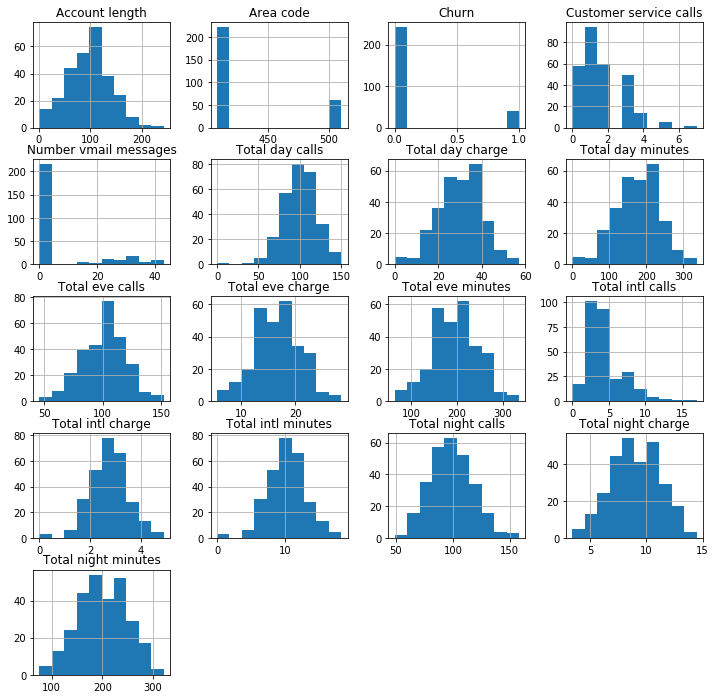

In [9]:
dfhelper.plot_histogram(df_train)

Most continuous variables have an approximately normal distribution. An exception is "Number of vmail messages" that seems to be bi-modal.Notice that our labels ("Churn") have two very inbalanced classes. There's a 6 to 1 ratio between the 0.0 and 1.0 classes.

## Pair-wise correlations: scatter matrix

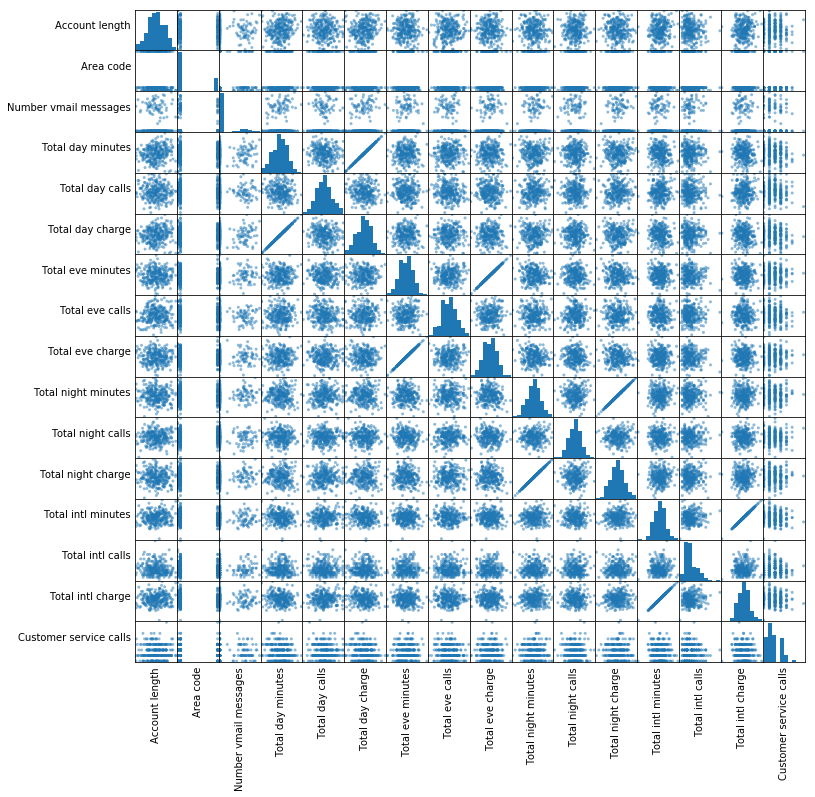

In [12]:
dfhelper.plot_scatter_matrix(df_train)

Some variables are practically 1:1 correlated with one another and then one of them should be considered.

## Correlations with the label: parallel coordinates plot

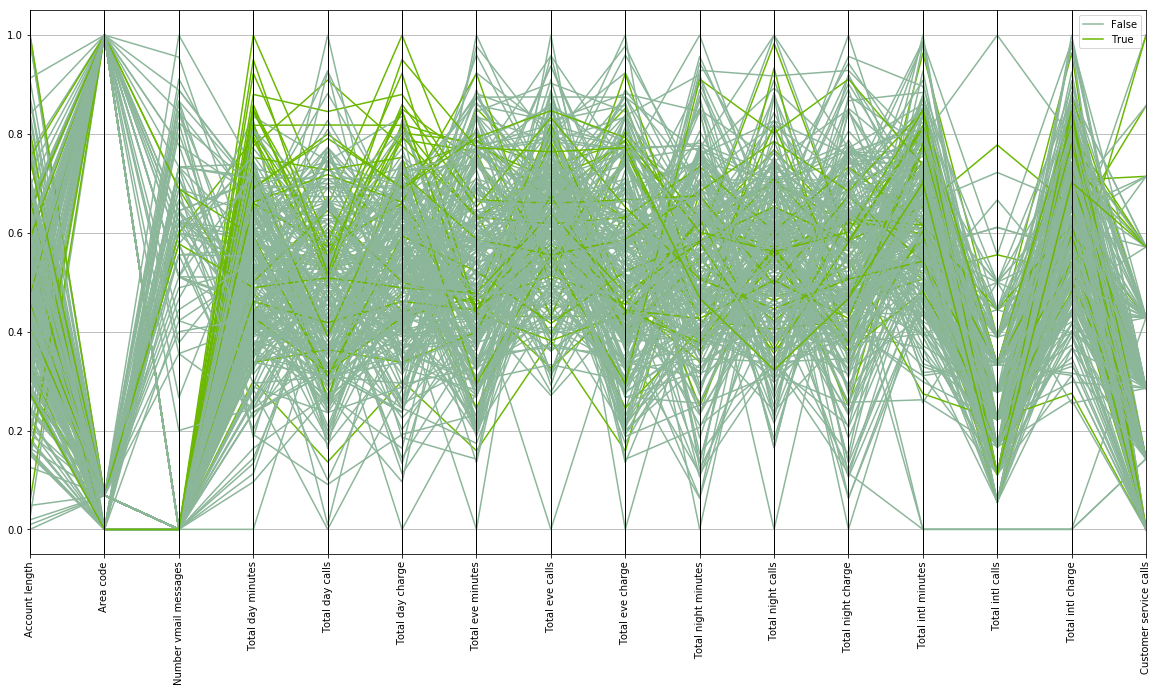

In [14]:
dfhelper.plot_parallel_coordinates(df_train, "Churn")

Most variables can't separate the "Churn" value by themselves. "Total day minutes" seems to do a slightly better job along with "Total day charge".

# Data cleaning and preprocessing

Basically, some columns may be redundant because they either don't correlate with the label at all (although in that case the variable could contribute to a highly nonlinear multi-variable term, but that's usually not very likely) or some variables correlate with each other so much that one could just pick one of them (e.g., "Total day minutes" and "Total day charge"). Also, any non-numeric categorical variables have to be converted to integers or floats before attempting any machine learning. This particular dataset didn't have nans, but checking and handling them is very easy in pyspark.

In [21]:
print "column types before processing:"
print df_train.dtypes
print

# drop some columns thought not as relevant:
drop_cols = ['State', 'Total day charge', 'Total eve charge', 
            'Total night charge', 'Total intl charge', 'Area code']
df_train_proc = dfhelper.drop_columns(df_train, drop_cols)
df_test_proc = dfhelper.drop_columns(df_test, drop_cols)

# convert string values to numeric
# can change the default string to number map when needed
df_train_proc = dfhelper.string_columns_to_numeric(df_train_proc)
df_test_proc = dfhelper.string_columns_to_numeric(df_test_proc)

# convert boolean values to numeric
df_train_proc = dfhelper.boolean_columns_to_numeric(df_train_proc)
df_test_proc = dfhelper.boolean_columns_to_numeric(df_test_proc)

print "column types after processing:"
print df_train_proc.dtypes

column types before processing:
[('State', 'string'), ('Account length', 'int'), ('Area code', 'int'), ('International plan', 'string'), ('Voice mail plan', 'string'), ('Number vmail messages', 'int'), ('Total day minutes', 'double'), ('Total day calls', 'int'), ('Total day charge', 'double'), ('Total eve minutes', 'double'), ('Total eve calls', 'int'), ('Total eve charge', 'double'), ('Total night minutes', 'double'), ('Total night calls', 'int'), ('Total night charge', 'double'), ('Total intl minutes', 'double'), ('Total intl calls', 'int'), ('Total intl charge', 'double'), ('Customer service calls', 'int'), ('Churn', 'boolean')]

column types after processing:
[('Account length', 'int'), ('International plan', 'int'), ('Voice mail plan', 'int'), ('Number vmail messages', 'int'), ('Total day minutes', 'double'), ('Total day calls', 'int'), ('Total eve minutes', 'double'), ('Total eve calls', 'int'), ('Total night minutes', 'double'), ('Total night calls', 'int'), ('Total intl minutes

In [22]:
spark.stop()

# Distributed neural net training and evaluation

## Training

The function below starts a spark session, loads and processes the training dataset, splits the data into training and validation sets, and then trains a keras neural net by drawing minibatches from the spark dataframe. This is accomplished by using batch generators during training. The class imbalance in the labels is taken into account by giving more weight to the less represented class using the "class_weight" input.

The neural net architecture consists of 3 hidden fully-connected layers (fc). The fc layers are followed by dropout layers (i.e., layers that randomly make some internal outputs equal to zero), but it was found during tests that weight regularization (i.e., adding a term to the loss such as zero weights are preferred) helped much more in training a model with better generalization (i.e., that performs better with never-seen samples).

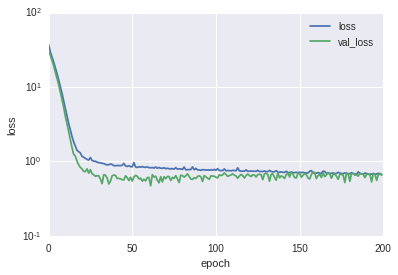

train loss: 0.435530394385
train acc: 0.925700942378

val loss: 0.470230475068
val acc: 0.92015209794
training history saved to: log/2018-08-02_19:12:39.536372/history.pkl
results saved to log/2018-08-02_19:12:39.536372


In [6]:
%matplotlib inline
import main; reload(main)

main. main(
    open_spark_gui=False,
    train_file='/data/churn-bigml-80.csv',
    drop_cols = ['State', 'Total day charge', 'Total eve charge',
                 'Total night charge', 'Total intl charge', 'Area code'],
    val_ratio=0.2, 
    seed=3,
    batch_size=256,
    input_shape=(None, 13),
    hidden_layers=[(256, 0.0), (256, 0.0), (256, 0.0)],
    nlabels=1,
    reg_weight=0.07,
    epochs=200,
    lr=0.001,
    decay=0,
    class_weight={0.0: 1., 1.0: 6.},
    save_to_dir='log',
    datetime_subdir=True,
)

## Evaluation on test set

The trained model is now evaluated on the set-aside data from the test file. Notice that the model has not seen this data either directly or indirectly during its training.

In [46]:
reload(main)
from main import start_session, get_df, process_columns, get_scaling, train_val_split
from keras.models import load_model
import sklearn.metrics

train_file='/data/churn-bigml-80.csv'
test_file='/data/churn-bigml-20.csv'
drop_cols = ['State', 'Total day charge', 'Total eve charge',
             'Total night charge', 'Total intl charge', 'Area code']
val_ratio = 0.2
seed = 3
batch_size=256
model_path = "log/2018-08-02_19:12:39.536372/keras_model.h5"
label_col = "Churn"

def custom_acc(y, ypred):
    return sklearn.metrics.accuracy_score(y, np.round(ypred))

def custom_pres(y, ypred):
    return sklearn.metrics.precision_score(y, np.round(ypred), average=None)

def custom_recall(y, ypred):
    return sklearn.metrics.recall_score(y, np.round(ypred), average=None)

def custom_f1(y, ypred):
    return sklearn.metrics.f1_score(y, np.round(ypred), average=None)

def custom_conf_matrix(y, ypred):
    n = float(len(y))
    mat = np.array(sklearn.metrics.confusion_matrix(y, np.round(ypred))) / n
    return mat

metrics = [
    custom_acc,
    custom_pres,
    custom_conf_matrix,
    custom_recall,
    custom_f1,
]
print "Test dataset evaluation:"
print

with start_session(False) as spark:
    df_train = get_df(
        train_file, spark, False,
    )
    df_test = get_df(
        train_file, spark, False,
    )
    df_train_proc = process_columns(
        df_train, drop_cols, False,
    )
    df_test_proc = process_columns(
        df_test, drop_cols, False,
    )
    df_partial_train, __ = train_val_split(
        df_train_proc, val_ratio, seed, False,
    )
    xmeans, xstds = get_scaling(df_partial_train)
    
    model = load_model(model_path)
    xcols = [x for x in df_test_proc.columns if "Churn" not in x]
    
    scores_dict = main.distributed_scoring(
            model,
            df_test_proc,
            xcols,
            label_col,
            batch_size=32,
            total_samples=None,
            metrics=metrics,
            xscaling=(xmeans, xstds),
            yscaling=(),
    )

Test dataset evaluation:

evaluated metrics:

custom_f1
[0.95502162 0.73262471]

custom_conf_matrix
[[0.81285369 0.04160962]
 [0.03378286 0.11175383]]

custom_acc
0.9246075209930632

custom_recall
[0.9516209  0.77578757]

custom_pres
[0.95991178 0.73400268]



Considering the little amount of data available and its imbalanced nature these results are pretty good. They compare favorably with the results from a [stratified sampling analysis](https://github.com/bensadeghi/pyspark-churn-prediction). The latter considered only a balanced subset of the data which might explain the better results here in which considerably more data was used to train the model. Notice also that no grid search for optimum training parameters was conducted here.

## Conclusions

A distributed procedure for data exploration and modeling was illustrated by leveraging together the capabilities of the pyspark and keras packages. Although the data used in this illustration is relatively small, the functions developed here are capable of handling large datasets. Moreover, by illustrating a simple way for dynamically generating minibatches using pyspark, the modules here allow the modeling of structured data in multi-input keras models such as the ones that transform categorical variables to a meaninful vector space using embedding layers.